# Телеком — задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

Во всех файлах столбец `customerID` содержит код клиента. Информация о договорах актуальна на 1 февраля 2020.

## Описание полей данных:
* BeginDate – дата начала пользования услугами,
* EndDate – дата окончания пользования услугами,
* Type – тип договора: ежемесячный, годовой и т.д,
* PaperlessBilling – факт выставления счёта на электронную почту,
* PaymentMethod – способ оплаты,
* MonthlyCharges – ежемесячные траты на услуги,
* TotalCharges – всего потрачено денег на услуги,
* Dependents – наличие иждивенцев,
* Senior Citizen – наличие пенсионного статуса по возрасту,
* Partner – наличие супруга(и),
* MultipleLines – наличие возможности ведения параллельных линий во время звонка.

Для оценки и обучения используется метрика ROC-AUC. Дополнительно можно смотреть - F1 и Accuracy.

Критерии оценки: минимальный порог для успешной сдачи AUC-ROC >= 0.85

При делении на выборки соотношение тренировочной к тестовой = 3/1.

## Проект:

### Загрузка данных

In [60]:
pip install phik;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [61]:
pip install catboost;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [62]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import time
import xgboost as xgb

import phik
from phik import resources, report

from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split, GridSearchCV 
from sklearn.utils import shuffle

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, make_scorer, roc_curve, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from statsmodels.stats.outliers_influence import variance_inflation_factor

from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore", category=RuntimeWarning)

In [63]:
from google.colab import drive   # подключение гугл-диска
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [64]:
data_path = '/content/drive/MyDrive/_PYTHON/YandexPracticum/final project/' # путь к датасетам

In [65]:
contract = pd.read_csv(data_path+'contract.csv') #  информация о договоре
personal = pd.read_csv(data_path+'personal.csv') #  персональные данные клиента
internet = pd.read_csv(data_path+'internet.csv') #  информация об интернет-услугах
phone =    pd.read_csv(data_path+'phone.csv')    #  информация об услугах телефонии

### Ознакомление с данными

In [66]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [67]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [68]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [69]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [70]:
contract.shape[0], personal.shape[0], internet.shape[0], phone.shape[0]

(7043, 7043, 5517, 6361)

Всего клиентов 7043. Телефон и интернет есть не у всех. Данные нужно свести в одну таблицу по `customerID` <br> Названия столбцов перевести в змеинный регистр.

In [71]:
print('Пользуются только телефоном:', contract.shape[0] - internet.shape[0])
print('Пользуются только интернетом:', contract.shape[0] - phone.shape[0])
print('Пользуются интернетом и телефоном:', phone.shape[0] + internet.shape[0] - contract.shape[0])

Пользуются только телефоном: 1526
Пользуются только интернетом: 682
Пользуются интернетом и телефоном: 4835


### Первичный анализ

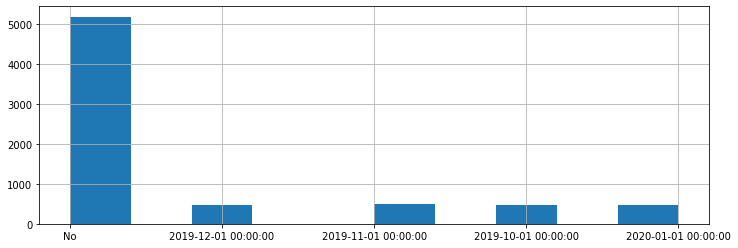

In [72]:
contract.EndDate.hist(figsize=(12,4));

Из столбца `EndDate` можно извлечь целевой признак: контракт окончен (клиент ушёл) - 1, действующий клиент - 0. <br>
Есть дисбаланс классов - действующих клиентов намного больше.

In [73]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Нужно поменять типы данных: 
* столбец `TotalCharges` c `object` на `float64` 
* столбцы `BeginDate` и `EndDate` c `object` на `datetime`
* столбцы `PaperlessBilling` и `PaymentMethod` можно сделать цифровыми

### Предвариательные выводы

Хватает ли данных можно будет понять после обучения моделей и их оценки по метрике AUC-ROC. Если оценка будет ниже 0.85 то необходимо будет добавить в датасет синтетических признаков. Помимо признака по длительности контракта это могут быть:
* признак по сумме контракта
* признак по количеству дополнительных услуг к интернету
* социальных признак (полная семья, неполная, с детьми, без детей, пенсионеры)

### План работ

* объединение данных в одну таблицу
* изменение типов данных
* выделение целевого признака
* добавление синтетических признаков (признак по длительности контракта и т.д.)
* заполнение пропусков
* разделение на выборки train и test в соотношении 3:1
* обучение трёх моделей: LogisticRegression, DecisionTreeClassifier и RandomForestClassifier
* оценка качества моделей на кросс-валидации и выбор лучшей по метрике AUC-ROC
* проверка лучшей модели на тестовой выборке
* портрет уходящего клиента
* выводы

### Объединение данных в одну таблицу

In [74]:
df = contract.merge(personal, on='customerID')
df = df.merge(internet, on='customerID', how='left')
df = df.merge(phone, on='customerID', how='left')

In [75]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [76]:
df.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines'],
      dtype='object')

In [77]:
df = df.rename(columns={'customerID': 'customer_id',
                        'BeginDate':'begin_date', 'EndDate':'end_date', 
                        'Type':'type', 'PaperlessBilling':'paperless_billing',
                        'PaymentMethod':'payment_method', 'MonthlyCharges':'monthly_charges', 
                        'TotalCharges':'total_charges', 'SeniorCitizen':'senior_citizen', 
                        'Partner':'partner', 'Dependents':'dependents', 
                        'InternetService':'internet_service','OnlineSecurity':'online_security', 
                        'OnlineBackup':'online_backup', 'DeviceProtection':'device_protection',
                        'TechSupport':'tech_support', 'StreamingTV':'streaming_tv', 
                        'StreamingMovies':'streaming_movies', 'MultipleLines':'multiple_lines'})

### Изменение типов данных и выделение целевого признака

In [78]:
df.shape

(7043, 20)

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

Изменение типов данных. Сперва в столбце `total_charges` с `object` на `float`

In [80]:
df.paperless_billing.unique(), df.partner.unique(), df.dependents.unique(), df.online_security.unique(), df.online_backup.unique(), df.device_protection.unique(), df.tech_support.unique(), df.streaming_tv.unique(), df.streaming_movies.unique(), df.multiple_lines.unique()

(array(['Yes', 'No'], dtype=object),
 array(['Yes', 'No'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes', nan], dtype=object),
 array(['Yes', 'No', nan], dtype=object),
 array(['No', 'Yes', nan], dtype=object),
 array(['No', 'Yes', nan], dtype=object),
 array(['No', 'Yes', nan], dtype=object),
 array(['No', 'Yes', nan], dtype=object),
 array([nan, 'No', 'Yes'], dtype=object))

10 столбцов, где можно поменять тип на `float` и значения `No`, `Yes` на `0`, `1`

In [81]:
df.type.unique(), df.gender.unique(), df.internet_service.unique(), df.payment_method.unique()  

(array(['Month-to-month', 'One year', 'Two year'], dtype=object),
 array(['Female', 'Male'], dtype=object),
 array(['DSL', 'Fiber optic', nan], dtype=object),
 array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
        'Credit card (automatic)'], dtype=object))

Два столбца с датами и столбцы `type`, `gender`, `internet_service` и `payment_method` где можно поменять тип с object на float или Int64

### Заполнение пропусков

In [82]:
df.duplicated().sum() # дубликатов нет

0

In [83]:
df.query('end_date == "2020-02-01 00:00:00"') # не было ли в исходном датасете клиентов, которые ушли в дату среза

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines


Нет, таких клиентов не было. Можно сделать замену датой

In [84]:
df['end_date'] = df['end_date'].replace(['No'], ['2020-02-01']) # подставим вместо 'No' актуальную дату

In [85]:
df['total_charges'] = df['total_charges'].replace([' '], 0) # замена пропусков нулевыми значениями

In [86]:
df['begin_date'] = pd.to_datetime(df['begin_date'],format = '%Y-%m-%d')  # столбцы begin_date и end_date в формат даты
df['end_date'] = pd.to_datetime(df['end_date'],format = '%Y-%m-%d')

In [87]:
df['monthly_charges'] = df['monthly_charges'].astype('int') # приведение к целочисленному типу
df['total_charges'] = df['total_charges'].astype('float')
df['total_charges'] = df['total_charges'].astype('int')

In [88]:
def coding_for_binary_features(df, column):          # Yes-No Функция
    df[column].fillna(0, inplace = True) # пропуск соответствует значению "No"
    df[column] = df[column].replace(['No'], 0)
    df[column] = df[column].replace(['Yes'], 1)
    return df[column]

In [89]:
df['multiple_lines'] = coding_for_binary_features(df, 'multiple_lines')     # Yes-No Функция
df['internet_service'] = coding_for_binary_features(df, 'internet_service')
df['online_security'] = coding_for_binary_features(df, 'online_security')
df['online_backup'] = coding_for_binary_features(df, 'online_backup')
df['device_protection'] = coding_for_binary_features(df, 'device_protection')
df['tech_support'] = coding_for_binary_features(df, 'tech_support')
df['streaming_tv'] = coding_for_binary_features(df, 'streaming_tv')
df['streaming_movies'] = coding_for_binary_features(df, 'streaming_movies')
df['partner'] = coding_for_binary_features(df, 'partner')
df['dependents'] = coding_for_binary_features(df, 'dependents')

In [90]:
df['is_male'] = df['gender'].replace(['Male'], 1).replace(['Female'], 0)    # добавим новые столбцы
df['paperless_billing'] = df['paperless_billing'].replace(['Yes'], 1).replace(['No'], 0)
df['is_DSL_service'] = df['internet_service'].replace(['DSL'], 1).replace(['Fiber optic'], 0)

In [91]:
df = df.drop(['gender', 'internet_service'], axis=1)   # удалим лишние столбцы

In [92]:
df['escape_client'] = (df['end_date'] != "2020-02-01") * 1  # добавим целевой признак 1 - если ушёл

In [93]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,senior_citizen,partner,...,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,is_male,is_DSL_service,escape_client
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29,29,0,1,...,0,1,0,0,0,0,0,0,1,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,0,Mailed check,56,1889,0,0,...,1,0,1,0,0,0,0,1,1,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53,108,0,0,...,1,1,0,0,0,0,0,1,1,1
3,7795-CFOCW,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42,1840,0,0,...,1,0,1,1,0,0,0,1,1,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70,151,0,0,...,0,0,0,0,0,0,0,0,0,1


In [94]:
df.info() # столбец customer_id нужно удалить, как неинформативный, столбцы type и payment_method - прямое кодирование

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   int64         
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   int64         
 7   total_charges      7043 non-null   int64         
 8   senior_citizen     7043 non-null   int64         
 9   partner            7043 non-null   int64         
 10  dependents         7043 non-null   int64         
 11  online_security    7043 non-null   int64         
 12  online_backup      7043 non-null   int64         
 13  device_protection  7043 non-null   int64         
 14  tech_sup

In [95]:
df.describe().T # транспонирование для удобства

,count,mean,std,min,25%,50%,75%,max
paperless_billing,7043.0,0.592219,0.491457,0.0,0.0,1.0,1.0,1.0
monthly_charges,7043.0,64.295897,30.092727,18.0,35.0,70.0,89.0,118.0
total_charges,7043.0,2279.265086,2266.790864,0.0,398.0,1394.0,3786.5,8684.0
senior_citizen,7043.0,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
partner,7043.0,0.483033,0.499748,0.0,0.0,0.0,1.0,1.0
dependents,7043.0,0.299588,0.458110,0.0,0.0,0.0,1.0,1.0
online_security,7043.0,0.286668,0.452237,0.0,0.0,0.0,1.0,1.0
online_backup,7043.0,0.344881,0.475363,0.0,0.0,0.0,1.0,1.0
device_protection,7043.0,0.343888,0.475038,0.0,0.0,0.0,1.0,1.0
tech_support,7043.0,0.290217,0.453895,0.0,0.0,0.0,1.0,1.0


In [96]:
df.query('total_charges == 0') # новые клиенты, которые ещё ничего не заплатили за год

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,senior_citizen,partner,...,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,is_male,is_DSL_service,escape_client
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,1,Bank transfer (automatic),52,0,0,1,...,1,0,1,1,1,0,0,0,1,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,0,Mailed check,20,0,0,0,...,0,0,0,0,0,0,0,1,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,0,Mailed check,80,0,0,1,...,1,1,1,0,1,1,0,0,1,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,0,Mailed check,25,0,0,1,...,0,0,0,0,0,0,1,1,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,0,Credit card (automatic),56,0,0,1,...,1,1,1,1,1,0,0,0,1,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,0,Mailed check,19,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,0,Mailed check,25,0,0,1,...,0,0,0,0,0,0,1,1,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,0,Mailed check,20,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,1,Mailed check,19,0,0,1,...,0,0,0,0,0,0,0,1,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,0,Mailed check,73,0,0,1,...,0,1,1,1,1,0,1,0,1,0


Это клиенты, начавшие пользоваться услугами в феврале 2020 года, в этом случае суммарные траты равны месячным (дата актуальности датасета - 2020-02-01

In [97]:
df.loc[df['total_charges'] == 0, 'total_charges'] = df['monthly_charges']

### Добавление синтетических признаков

#### Признак по длительности контракта

Введем признак соответствующий длительности пользования клиентом услугами компании:

In [98]:
df['total_time'] = (df['end_date'] - df['begin_date']).dt.days

#### Признак по сумме контракта - тип клиента

In [99]:
df.total_charges.describe() # 25% всех контрактов на сумму меньше 400 руб

count    7043.000000
mean     2279.328979
std      2266.727362
min        18.000000
25%       398.000000
50%      1394.000000
75%      3786.500000
max      8684.000000
Name: total_charges, dtype: float64

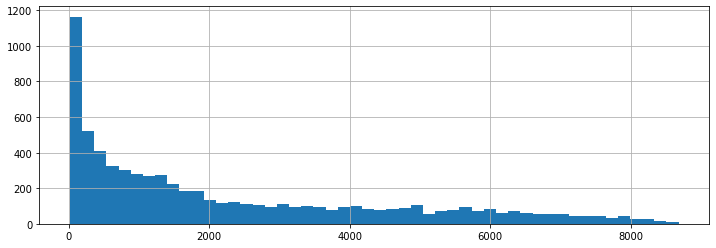

In [100]:
df.total_charges.hist(bins=50, figsize=(12,4));

In [101]:
for i in range(len(df)):                    # Сделаем 4 категории: до 400, до 1400, до 4000, выше 4000
    if df.loc[i,'total_charges'] > 4000:
        df.loc[i,'type_client'] = 3
    elif (df.loc[i,'total_charges'] <= 4000) and (df.loc[i,'total_charges'] > 1400): 
        df.loc[i,'type_client'] = 2
    elif (df.loc[i,'total_charges'] <= 1400) and (df.loc[i,'total_charges'] < 400): 
        df.loc[i,'type_client'] = 1
    else:
        df.loc[i,'type_client'] = 0 

In [102]:
df.type_client = df.type_client.astype(int)

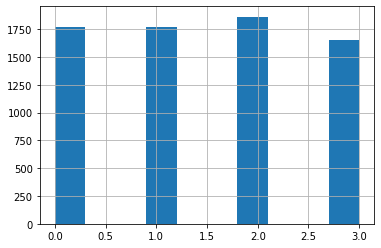

In [103]:
df.type_client.hist(); # распределил почти поровну

####  Признак по количеству дополнительных услуг к интернету

In [104]:
for i in range(len(df)):
    if (df.loc[i,'online_security']==1 or df.loc[i,'online_backup']==1 or df.loc[i,'device_protection']==1 or
        df.loc[i,'tech_support']==1 or df.loc[i,'streaming_tv']==1 or df.loc[i,'streaming_movies']==1):
        df.loc[i,'additional_services'] = 1
    else:
        df.loc[i,'additional_services'] = 0

In [105]:
df.additional_services.describe()

count    7043.000000
mean        0.684935
std         0.464575
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: additional_services, dtype: float64

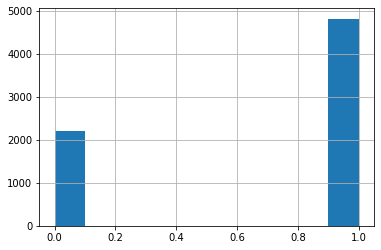

In [106]:
df.additional_services.hist(); # примерно треть клиентов не берут доп.услуги по интернету

### Разделение на выборки train и test в соотношении 3:1

In [107]:
RANDOM_STATE = 270223

In [108]:
df = df.drop(['customer_id', 'begin_date', 'end_date'], axis=1) # удалим номер пользователя и признаки с датой

In [109]:
df.shape # количество признаков, включая целевой

(7043, 21)

interval columns not set, guessing: ['paperless_billing', 'monthly_charges', 'total_charges', 'senior_citizen', 'partner', 'dependents', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines', 'is_male', 'is_DSL_service', 'escape_client', 'total_time', 'type_client', 'additional_services']


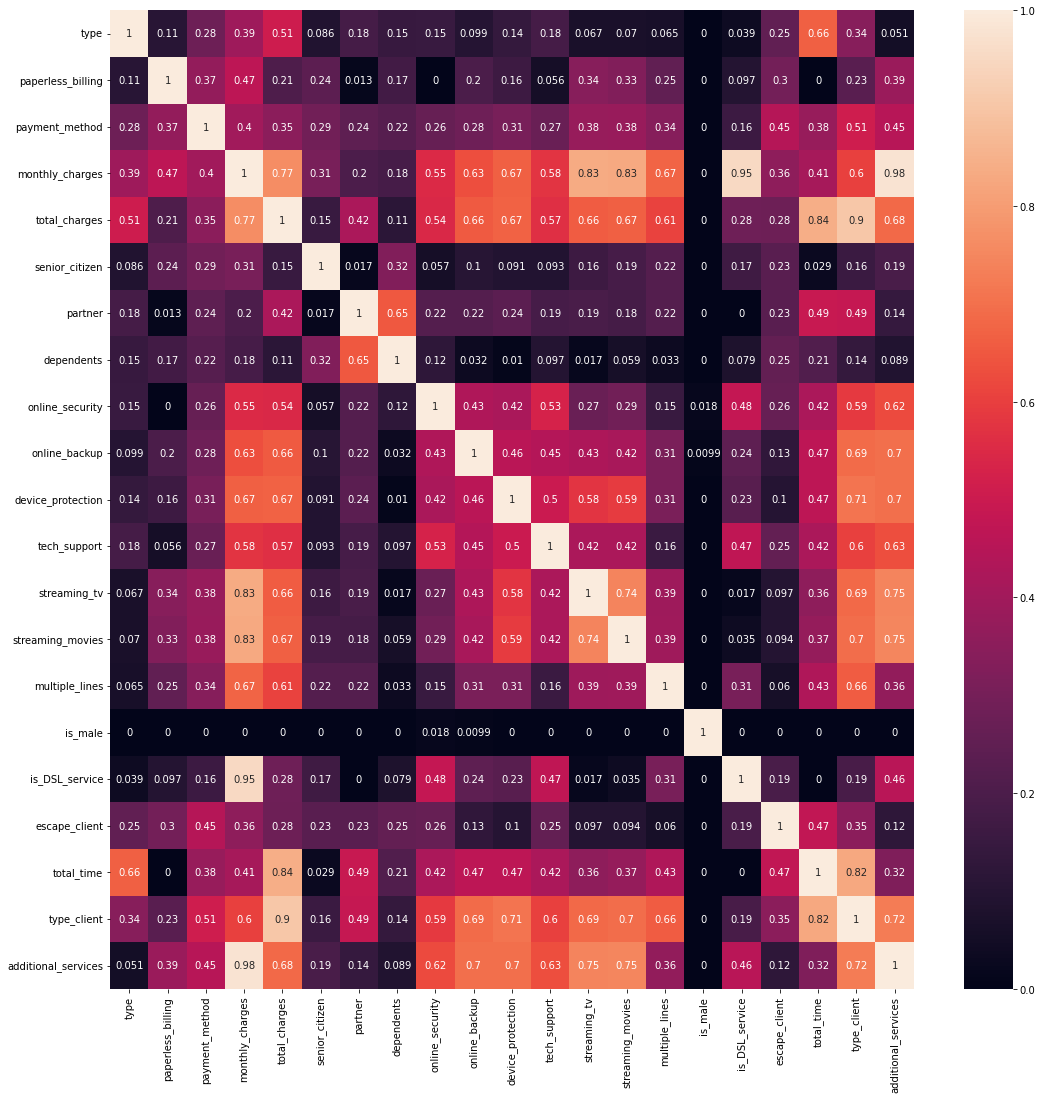

In [110]:
corrMatrix = df.phik_matrix();      # тепловая карта матрицы парных корреляций признаков
plt.figure(figsize=(18, 18))
sns.heatmap(corrMatrix, annot=True);

* целевой признак больше всего коррелирует с `total_time`, что логично, и `payment_method`  а также с синтетическим `type_client`    

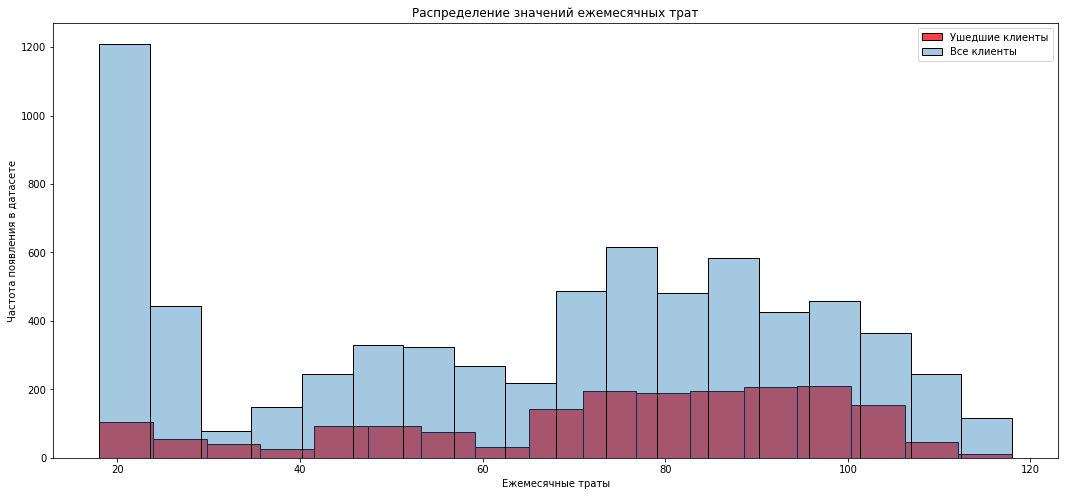

In [111]:
plt.figure(figsize=(18, 8))
ax = sns.histplot(df.loc[df['escape_client'] == 1,'monthly_charges'], color='r', label='Ушедшие клиенты')
sns.histplot(df['monthly_charges'], ax=ax, alpha=0.4, label='Все клиенты')
ax.legend()
plt.title('Распределение значений ежемесячных трат')
plt.xlabel('Ежемесячные траты')
plt.ylabel('Частота появления в датасете');

Среди оставшихся больше тех, кто пользуется самым дешевым тарифом.

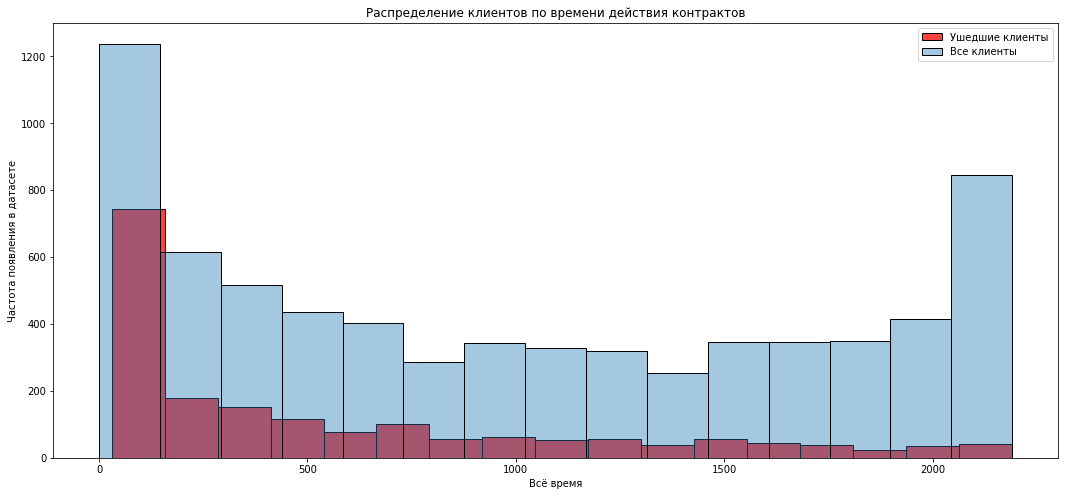

In [112]:
plt.figure(figsize=(18, 8))
ax = sns.histplot(df.loc[df['escape_client'] == 1,'total_time'], color='r', label='Ушедшие клиенты')
sns.histplot(df['total_time'], ax=ax, alpha=0.4, label='Все клиенты')
ax.legend()
plt.title('Распределение клиентов по времени действия контрактов')
plt.xlabel('Всё время')
plt.ylabel('Частота появления в датасете');

Чем дольше клиент остаётся, тем меньше вероятность его ухода

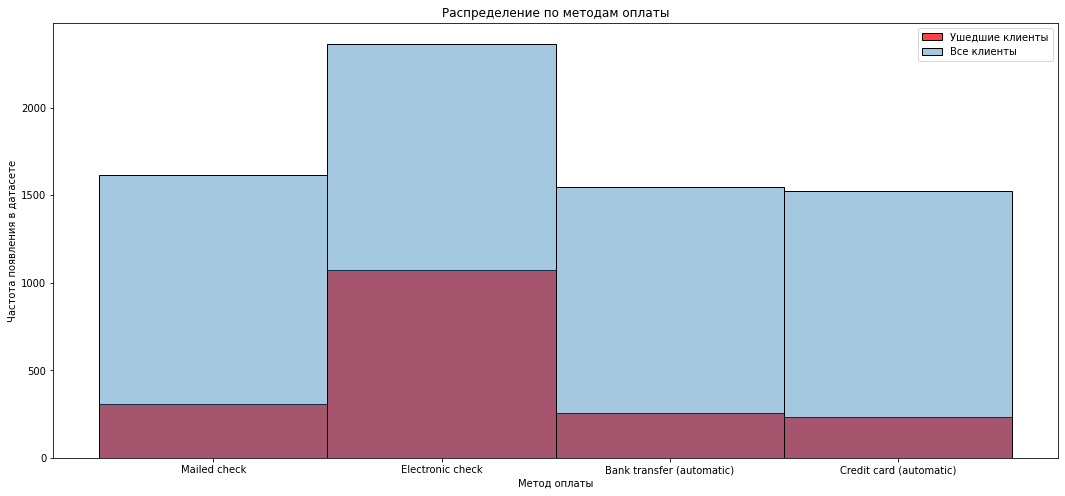

In [113]:
plt.figure(figsize=(18, 8))
ax = sns.histplot(df.loc[df['escape_client'] == 1,'payment_method'], color='r', label='Ушедшие клиенты')
sns.histplot(df['payment_method'], ax=ax, alpha=0.4, label='Все клиенты')
ax.legend()
plt.title('Распределение по методам оплаты')
plt.xlabel('Метод оплаты')
plt.ylabel('Частота появления в датасете');

Больше всего клиентов с электронным типом оплаты, но они чаще и уходят

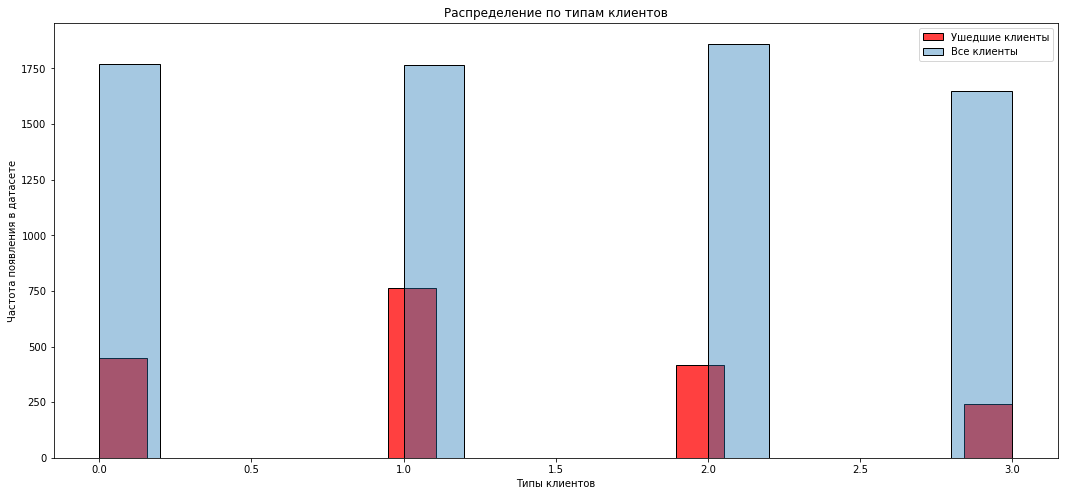

In [114]:
plt.figure(figsize=(18, 8))
ax = sns.histplot(df.loc[df['escape_client'] == 1,'type_client'], color='r', label='Ушедшие клиенты')
sns.histplot(df['type_client'], ax=ax, alpha=0.4, label='Все клиенты')
ax.legend()
plt.title('Распределение по типам клиентов')
plt.xlabel('Типы клиентов')
plt.ylabel('Частота появления в датасете');  # 4 категории: 0 - до 400, 1 - до 1400, 2 - до 4000, 3 -выше 4000

Больше всего ушедших клиентов из группы 1: сумма контракта от 400 до 1400

In [115]:
target = df['escape_client'] # отделение целевого признака

In [116]:
features = df.drop('escape_client', axis=1)

In [117]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            train_size=.75, 
                                                                            random_state=RANDOM_STATE,
                                                                            stratify=target)

In [118]:
features_train.shape # количество признаков, не включая целевой

(5282, 20)

In [119]:
features_train = pd.get_dummies(features_train, drop_first=True) # Закодируем два оставшихся нечисловых признака прямым кодированием

In [120]:
features_test = pd.get_dummies(features_test, drop_first=True) 

In [121]:
features_train.columns == features_test.columns # проверка

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [122]:
features_train.shape # добавилось 3 числовых признака (стало 5 вместо 2 нечисловых)

(5282, 23)

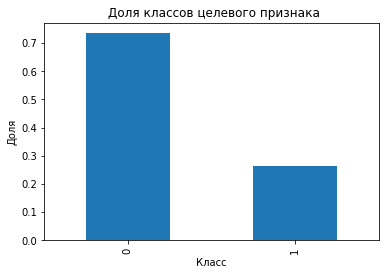

In [123]:
class_frequency = target.value_counts(normalize = True)
class_frequency.plot(kind = 'bar')
plt.xlabel('Класс')
plt.ylabel('Доля')
plt.title(' Доля классов целевого признака');  # дисбаланс классов присутствует

#### Базовая выборка с синтетическими признаками

In [124]:
pd.Series([variance_inflation_factor(features_train.values, i)for i in range(features_train.shape[1])],
          index=features_train.columns) # коэффициент инфляции диспресии:

paperless_billing                          2.898354
monthly_charges                           21.935119
total_charges                             20.741330
senior_citizen                             1.362902
partner                                    2.846705
dependents                                 1.997573
online_security                            2.240953
online_backup                              2.475550
device_protection                          2.437469
tech_support                               2.253329
streaming_tv                               3.034830
streaming_movies                           3.056863
multiple_lines                             2.622923
is_male                                    1.958775
is_DSL_service                             2.707695
total_time                                15.467454
type_client                                9.021862
additional_services                       11.848458
type_One year                              1.934923
type_Two yea

Признаки `monthly_charges`, `total_charges` и `total_time` имееют очень большой коэффициент инфляции дисперсии. 

In [125]:
features_train.shape, target_train.shape, features_test.shape, target_test.shape # количество признаков

((5282, 23), (5282,), (1761, 23), (1761,))

### Обучение и оценка качества моделей на кросс-валидации. Выбор лучшей по метрике AUC-ROC

In [126]:
stats = pd.DataFrame() # для собирания статистики

In [127]:
def metrics(model_1, features_1, target_1, sample_name_1):   # проверка с 5-х кратной кросс валидацией
    f1 = np.mean(cross_val_score(model_1, features_1, target_1, cv=5, scoring=make_scorer(f1_score)))
    auc_roc = np.mean(cross_val_score(model_1, features_1, target_1, cv=5, scoring='roc_auc'))
    index = len(stats)
    stats.loc[index+1,'Mодель'] = str(model_1)[0:15]
    stats.loc[index+1,'Выборка'] = sample_name_1
    stats.loc[index+1,'Метрика F1'] = f1
    stats.loc[index+1,'AUC-ROC'] = auc_roc
    return print('Метрика F1:', f1, '\nМетрика AUC-ROC:', auc_roc)    

In [128]:
def super_model(model_2, features_2, target_2, sample_name_2):
    start_time = time.time()
    model_2.fit(features_2, target_2)
    metrics(model_2, features_2, target_2, sample_name_2)
    print(round((time.time() - start_time),1),'сек')
    return model_2

#### LogisticRegression

In [129]:
model_lg = LogisticRegression(random_state=RANDOM_STATE, solver='lbfgs', max_iter=1000, class_weight='balanced') 

In [130]:
model_lgt = super_model(model_lg, features_train, target_train, 'тренировочная')

Метрика F1: 0.6216861028083611 
Метрика AUC-ROC: 0.8370522562356196
5.7 сек


#### DecisionTreeClassifier

In [131]:
dt_parameters = {
    'max_depth': [2, 3, 4, 5],
    'splitter': ['best', 'random'],
    'criterion': ['gini', 'entropy', 'log_loss']}

In [132]:
dt_model = DecisionTreeClassifier(random_state=RANDOM_STATE) 

In [133]:
dt_grid = GridSearchCV(dt_model, param_grid=dt_parameters) # подбор наилучших параметров

In [134]:
best_decision_tree_model = dt_grid.fit(features_train, target_train)
print('Наилучшие параметры для Decision Tree: {}'.format(best_decision_tree_model.best_params_))

Наилучшие параметры для Decision Tree: {'criterion': 'gini', 'max_depth': 4, 'splitter': 'best'}


Обучим модель DecisionTreeClassifier с наилучшими параметрами

In [135]:
model_dtc = dt_grid.best_estimator_

In [136]:
model_dtct = super_model(model_dtc, features_train, target_train, 'тренировочная')

Метрика F1: 0.5463549726704635 
Метрика AUC-ROC: 0.8222678790900371
0.9 сек


#### RandomForestClassifier

In [137]:
rf_parameters = {
    'n_estimators': [5, 10, 20, 50],
    'max_depth': [2, 3, 7],
    'criterion': ['gini', 'entropy', 'log_loss']}

In [138]:
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)

In [139]:
rf_grid = GridSearchCV(estimator=rf_model, param_grid=rf_parameters) # подбор наилучших параметров

In [140]:
best_random_forest_model = rf_grid.fit(features_train, target_train)
print('Наилучшие параметры для Random Forest: {}'.format(best_random_forest_model.best_params_))

Наилучшие параметры для Random Forest: {'criterion': 'gini', 'max_depth': 7, 'n_estimators': 50}


In [141]:
model_rfc = rf_grid.best_estimator_

In [142]:
model_rfct = super_model(model_rfc, features_train, target_train, 'тренировочная')

Метрика F1: 0.5797748856918629 
Метрика AUC-ROC: 0.8540120231238107
3.3 сек


#### CatBoostClassifier

In [143]:
train_dataset = Pool(features_train, target_train) # Пул - используется в CatBoost в качестве структуры данных для обучения модели
test_dataset = Pool(features_test, target_test)

In [144]:
model_cbc = CatBoostClassifier(random_state=RANDOM_STATE, learning_rate=0.03, loss_function = 'CrossEntropy', silent=True) 

In [145]:
model_cbc.fit(train_dataset, eval_set = test_dataset, verbose = False);

In [146]:
model_cbct= super_model(model_cbc, features_train, target_train, 'тренировочная')

Метрика F1: 0.694134199392383 
Метрика AUC-ROC: 0.900763678334268
45.9 сек


### Проверка лучшей модели на тестовой выборке

In [147]:
stats # статистика по моделям

,Mодель,Выборка,Метрика F1,AUC-ROC
1,LogisticRegress,тренировочная,0.621686,0.837052
2,DecisionTreeCla,тренировочная,0.546355,0.822268
3,RandomForestCla,тренировочная,0.579775,0.854012
4,<catboost.core.,тренировочная,0.694134,0.900764


Лучшая модель с AUC-ROC=0.90  catboost на тренировочной выборке. Проверим её на тестировочной выборке

In [151]:
predictions_test = model_cbct.predict(features_test)
probabilities_test = model_cbct.predict_proba(features_test)[:,1]

In [152]:
f1 = f1_score(target_test, predictions_test)             
auc_roc = roc_auc_score(target_test, probabilities_test)
print('Метрика F1:', f1, '\nМетрика AUC-ROC:', auc_roc) 

Метрика F1: 0.7067307692307693 
Метрика AUC-ROC: 0.9104440193414507


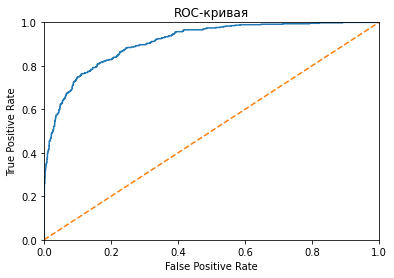

In [153]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_test) 
plt.figure()
plt.plot(fpr, tpr)   # ROC-кривая
plt.plot([0, 1], [0, 1], linestyle='--') # ROC-кривая случайной модели (выглядит как прямая)
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

### Портрет уходящего клиента

In [154]:
train_dataset = Pool(features_train, target_train)
feature_importance = model_cbct.get_feature_importance(train_dataset, prettified = True)
feature_importance

,Feature Id,Importances
0,total_time,43.276159
1,monthly_charges,12.682569
2,total_charges,8.277552
3,type_Two year,5.168275
4,payment_method_Electronic check,3.012504
5,is_DSL_service,2.688538
6,paperless_billing,2.421584
7,type_One year,2.414064
8,type_client,2.180368
9,is_male,2.169372


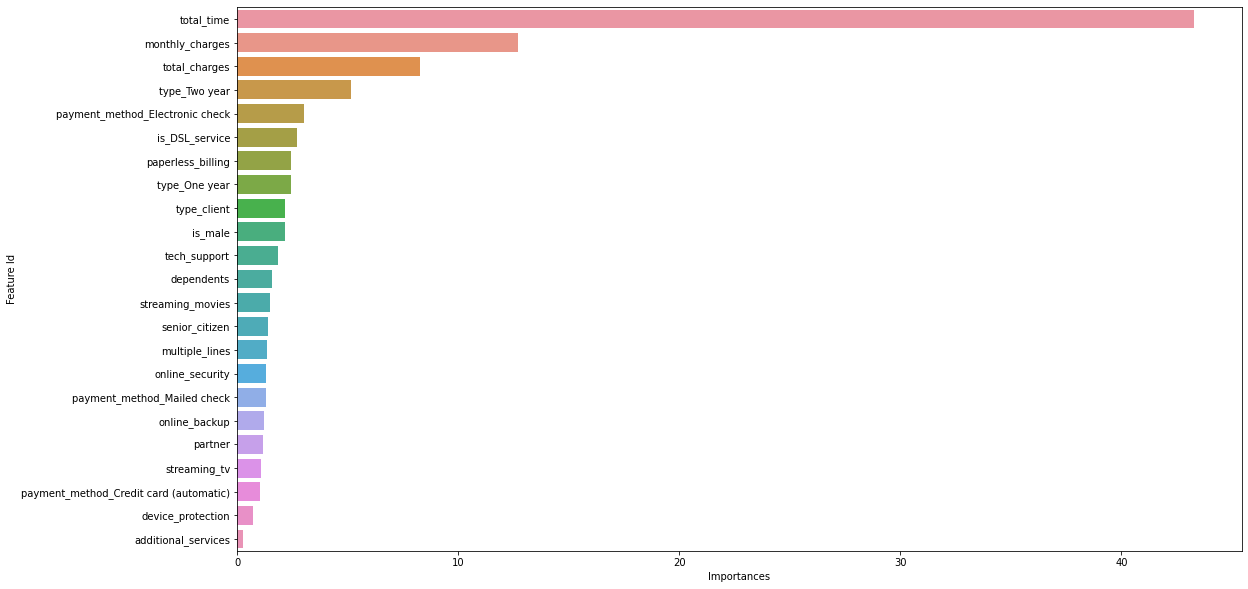

In [155]:
plt.figure(figsize=(18, 10))
sns.barplot(y=feature_importance['Feature Id'], x=feature_importance['Importances']);

Самый важный признак `total_time` - время действия контракта - время лояльности клиента, далее идут месячные траты и общие траты за всё время контракта 

### Отчёт

В результате работы были выполнены все пункты намеченного плана действий. Были загружены и рассмотрены начальные датасеты:
* `df_contract`
* `df_internet`
* `df_personal`
* `df_phone`

После ознакомления с данными, выяснилось, что из общего числа 7043 клиентов, телефон есть у 6361, а интернет у 5517 клиентов. То есть пользуются только телефоном 1526 клинтов, а только интернетом 682 клиента. Сразу обеими услугами пользуются 4835 клиентов. Данные были сведены в одну таблицу по `customerID`. Названия столбцов переведены в змеинный регистр.

Замечен дисбаланс по столбцу `end_date` : действующих клиентов намного больше, чем ушедших. Из этого столбца в дальнейшем будет извлёчен целевой признак: контракт окончен (клиент ушёл) - 1, действующий клиент - 0

Большинство данных типа `object`, который не подходит для анализа. Поэтому:
* `begin_date` – столбец приведён к типу `datetime`
* `end_date` – после проверки, что в исходном датасете нет клиентов, которые ушли в дату среза, значения "No" заменены датой актуальности датасета – 2020-02-01. Затем столбец был приведён к типу `datetime`
* `monthly_charges` – столбец приведен к целочисленному типу для экономии памяти (два знака после запятой - излишняя точность в значениях)
* `total_charges` – неявные пропуски (пустые значения) – новые клиенты, которые пришли в дату среза и ещё ничего не заплатили за год, приравнены к ненулевым значениям в `monthly_charges`. Затем столбец приведен к целочисленному типу.
* 13 признаков, содержащих значения "Yes" и "No" приведены к целочисленному виду со значениями "1" и "0", соответственно.
* 2 оставшихся признака, содержащих по 3 варианта значений, закодированы прямым кодированием после разбиения выборки на тестовую и тренировочную. При этом общее кол-во признаков увеличилось на 3.


Добавлены 3 синтетических признака:
* `total_time` – количество дней между открытием контракта и закрытием
* `type_client` – тип клиента по сумме контракта
* `additional_services` – наличие дополнительных услуг к интернету (1 – есть хоть одна доп.услуга)

И целовой признак `escape_client` на основе признака `end_date`

Перед разбиением исходной выборки размером 7043х24 были удалены 3 незначимых для анализа признака – `customer_id` и столбцы с датами. Отделён целевой признак, выборка разделена на train и test в соотношении 3:1

При рассмотрении матрицы корреляций Phi_K замечено, что целевой признак больше всего коррелирует с `total_time`, что логично, и `payment_method`, а также с синтетическим `type_client` 

При рассмотрении распределения в разрезе таргета замечено, что ушедшие клиенты пользовались в основном дорогими тарифами. Возможно, что это их и отпугнуло. При этом, тех клиентов, кто ушедших клиентов, кто заплатил мало, больше, чем ушедших, кто заплатил много. 

Два признака с действительными значениями `monthly_charges` и `total_time` имеют самые большие коэффициенты инфляции диспресии. 

Обучены 4 модели: `LogisticRegression`, `DecisionTreeClassifier`, `RandomForestClassifier` и `CatBoostClassifier`

Для двух из них – `DecisionTreeClassifier`, `RandomForestClassifier` автоматический выполнен подбор параметров при помощи GridSearchCV.

Лучшей моделью с AUC-ROC=0.90 оказалась `CatBoostClassifier` на полной тренировочной выборке. На тесте она показала такой же высокий результат 0.91

Пять наиболее значимых признака получились такие:
1.	total_time	43.276159
2.	monthly_charges	12.682569
3.	total_charges	8.277552
4.	type_Two year	5.168275
5.	payment_method_Electronic check	3.012504

На первом месте с большим отрывом признак `total_time` – суммарное время по договору. Если клиент долго остается, значит его всё устраивает и он не собирается уходить. На втором и третьем по значимости местах – траты за месяц и за всё время договора. На четвертом – двухлетний тип договора. Если клиент его подписал, то у него серьёзные намерения на долговременное сотрудничество. 

Итоговая модель `CatBoostClassifier`, которая при гиперпараметрах: {random_state=270223, learning_rate=0.03, loss_function = 'CrossEntropy'} показала точность по AUC-ROC=0.91. Наиболее важные признаки модели: `total_time`, `monthly_charges` и `total_charges`